#importing libraries.

In [84]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor ,RandomForestRegressor
from sklearn import set_config
set_config(transform_output='pandas')

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
#loading data
data='/content/drive/MyDrive/CodingDojo/02-IntroML/Week07/Data/Belt2_A_drugtype_v2_final.csv'
df=pd.read_csv(data)
df.head()


,Age,Gender,BP,Cholesterol,Na_to_K,Drug
0,59.0,M,High,HIGH,13.935,drugQ
1,40.0,F,Normal,HIGH,10.103,drugZ
2,NaN,M,Normal,HIGH,9.084,drugZ
3,62.0,M,Normal,HIGH,16.594,drugZ
4,55.0,F,High,NORMAL,10.977,drugQ


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          237 non-null    float64
 1   Gender       296 non-null    object 
 2   BP           221 non-null    object 
 3   Cholesterol  296 non-null    object 
 4   Na_to_K      296 non-null    object 
 5   Drug         296 non-null    object 
dtypes: float64(1), object(5)
memory usage: 14.0+ KB


In [49]:
#checking for duplicates.
df.duplicated().sum()

15

In [50]:
#dropping duplicates.
df=df.drop_duplicates()
df.duplicated().sum()

0

In [51]:
#checking for null values.
df.isna().sum()

Age            54
Gender          0
BP             75
Cholesterol     0
Na_to_K         0
Drug            0
dtype: int64

In [52]:
#addressing inconsistencies in gender.
df['Gender'].value_counts()

Gender
M         140
F         131
male        4
female      2
Female      1
Male        1
femal       1
Femal       1
Name: count, dtype: int64

In [53]:
#addressing inconsistencies.
df['Gender']=df['Gender'].replace({'M':'Male','male':'Male','female':'Female','femal':'Female','Femal':'Female','F':'Female'})
df['Gender'].value_counts()

Gender
Male      145
Female    136
Name: count, dtype: int64

In [54]:
#changing datatypes
df['Drug'].value_counts()

Drug
drugZ    147
drugQ    134
Name: count, dtype: int64

#ASSUMPTIONS
##assuming 0 represents drugQ.
##assuming 1 represents drugZ

In [55]:
df['Drug'] = df['Drug'].replace({"drugQ":'0',"drugZ":'1'})
df['Drug'].head()

0    0
1    1
2    1
3    1
4    0
Name: Drug, dtype: object

#addressing typing error in age

In [56]:
#inspecting numeric values and addressing inconsistencies.
df['Age'].value_counts()

Age
36.0     8
55.0     7
61.0     7
32.0     7
42.0     7
26.0     6
39.0     6
67.0     6
53.0     6
37.0     6
60.0     6
23.0     6
43.0     6
31.0     6
28.0     6
57.0     5
70.0     5
49.0     5
47.0     4
40.0     4
24.0     4
45.0     4
19.0     4
48.0     4
50.0     4
65.0     4
56.0     4
59.0     4
58.0     4
69.0     4
29.0     4
44.0     4
20.0     4
74.0     3
35.0     3
66.0     3
73.0     3
72.0     3
62.0     3
18.0     3
22.0     3
54.0     3
71.0     2
41.0     2
64.0     2
51.0     2
21.0     2
30.0     2
52.0     2
34.0     2
38.0     2
15.0     2
16.0     2
46.0     2
63.0     1
33.0     1
25.0     1
570.0    1
68.0     1
Name: count, dtype: int64

In [63]:
df['Age'].describe()

count    227.000000
mean      47.475771
std       38.359652
min       15.000000
25%       32.000000
50%       45.000000
75%       59.000000
max      570.000000
Name: Age, dtype: float64

In [65]:
filter_typo=df['Age']==570.0
df.loc[filter_typo,'Age']=np.nan
df['Age'].describe()

count    226.000000
mean      45.163717
std       16.098439
min       15.000000
25%       32.000000
50%       44.500000
75%       58.750000
max       74.000000
Name: Age, dtype: float64

#exploratory data visualisations.

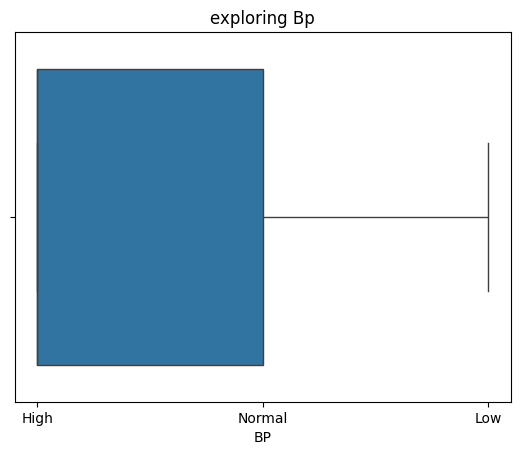

In [67]:
# Horizontal grouped boxplot in seaborn
ax = sns.boxplot(data=df, x='BP')
ax.set_title("exploring Bp");


#high and normal blood pressure are more common compared to low blood pressure.

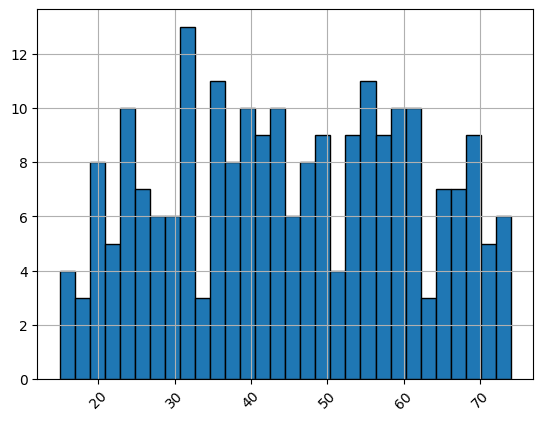

In [68]:
#histogram to visualise age distribution.
ax = df['Age'].hist(bins = 30,edgecolor = 'black')
ax.tick_params(axis='x', rotation = 45)
ax.ticklabel_format(style='plain')


# the estimated ages of 64,34 and 18 have the lowest number of individuals and an estimate of 34 has the highest number of individuals.

In [69]:
# Create features matrix and target vector
X = df.drop(columns = ['Drug'])
y = df['Drug']
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [70]:
#inspecting
display(X_train.head(3), y_train.head(3))

,Age,Gender,BP,Cholesterol,Na_to_K
68,53.0,Female,High,NORMAL,12.495
215,31.0,Male,NaN,NORMAL,10.292
110,NaN,Male,Low,HIGH,16.31


68     0
215    0
110    1
Name: Drug, dtype: object

In [71]:
type(y)

pandas.core.series.Series

#my comment on one hot encoding and ordinal encoding is that these two methods help us in changing our data from object to intengers. so whereas ordinal encoding requires one to scale the data later one hot encoding does not though both involve a using many codes making pipelines the best option.

In [72]:
#numeric pipelines
num_cols = X_train.select_dtypes("number").columns
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_median, scaler)
num_pipe


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [75]:
#ordinal pipelines
ord_cols =['Gender']
impute_na_ord = SimpleImputer(strategy='constant', fill_value='NA')
qual_cond_order = ['Female','Male']
ordinal_category_orders=[qual_cond_order]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
scaler_ord = StandardScaler()
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_pipe


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Female', 'Male']])),
                ('standardscaler', StandardScaler())])

In [76]:
#nominal pipeline
ohe_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [77]:
# categorical tuple
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['BP', 'Cholesterol', 'Na_to_K'], dtype='object'))

In [78]:
#numeric tuple
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Age'], dtype='object'))

In [79]:
#ordinal tuple
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Female', 'Male']])),
                 ('standardscaler', StandardScaler())]),
 ['Gender'])

In [80]:
# run a column transformer
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)

#bagged trees model.

In [81]:
# bagged model
bagreg = BaggingRegressor(random_state = 42)
bagreg_pipe = make_pipeline(col_transformer, bagreg)
bagreg_pipe.fit(X_train, y_train)
evaluate_regression(bagreg_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 0.076
- MSE = 0.024
- RMSE = 0.154
- R^2 = 0.905

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 0.207
- MSE = 0.133
- RMSE = 0.365
- R^2 = 0.449


In [82]:
#fine tuning the model.
param_grid = {'baggingregressor__n_estimators': [5, 10, 20, 30, 40, 50],
              'baggingregressor__max_samples' : [.5, .7, .9, ],
              'baggingregressor__max_features': [.5, .7, .9 ]}
gridsearch = GridSearchCV(bagreg_pipe, param_grid, n_jobs=-1, verbose=1)
gridsearch.fit(X_train, y_train)
best_bagreg_grid = gridsearch.best_estimator_
evaluate_regression(best_bagreg_grid, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 0.122
- MSE = 0.030
- RMSE = 0.172
- R^2 = 0.882

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 0.243
- MSE = 0.109
- RMSE = 0.331
- R^2 = 0.547


#random forests.

In [86]:
# Instantiate, model,fit and evaluate
rf = RandomForestRegressor(random_state = 42)
rf_pipe = make_pipeline(col_transformer, rf)
rf_pipe.fit(X_train, y_train)
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 0.083
- MSE = 0.022
- RMSE = 0.149
- R^2 = 0.911

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 0.222
- MSE = 0.134
- RMSE = 0.366
- R^2 = 0.447


In [87]:
#define params and tune
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)
gridsearch.fit(X_train, y_train)
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)


Fitting 3 folds for each of 288 candidates, totalling 864 fits
------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 0.198
- MSE = 0.085
- RMSE = 0.291
- R^2 = 0.661

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 0.270
- MSE = 0.138
- RMSE = 0.372
- R^2 = 0.428


#EVALUATING THE MODELS.
#focusing on MAE and R^2
#bagged model has a MAE of 0.245 and R^2 of 0.547.
#randomforest model has a MAE of 0.270 and R^2 of 0.428

#based on those results the bagged model is my model of choice because of the R^2 which shows the model performs better there.